# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))

dog_files   = np.array(glob("/data/dog_images/*/*/*"))
# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))
print('dog :',dog_files[110])

There are 13233 total human images.
There are 8351 total dog images.
dog : /data/dog_images/train/055.Curly-coated_retriever/Curly-coated_retriever_03883.jpg


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [18]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
print(human_files[0])
print('shape :',img.shape)
print()

/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg
shape : (250, 250, 3)



Number of faces detected: 1


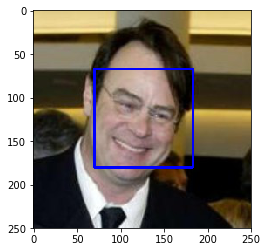

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [34]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img   = cv2.imread(img_path)
    gray  = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [35]:
human_files_short = human_files[:100]
dog_files_short   = dog_files[:100]
count = 0
for i in range(0,100):
    if face_detector(human_files_short[i]):
        count += 1
print('% Human images detected out of 100 are: {}%'.format(100*count/100))
count =0
for i in range(0,100):
    if face_detector(dog_files_short[i]):
        count += 1
print("% Dog images than have human's deteced out of 100 are: {}%".format(100*count/100))

% Human images detected out of 100 are: 98.0%
% Dog images than have human's deteced out of 100 are: 17.0%


In [7]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short   = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
count=0
print('*** Performance of the face_detector when applied to human images  ')
t=tqdm(range(100))
for i in t:
    if face_detector(human_files_short[i]):
        #print('i is  now: {}'.format(i))
        count += 1
t.clear()
print('% Human images detected out of 100 are: {}%'.format(100*count/100),'\n')
t=tqdm(range(100))
count=0
print('\n*** Performance of the face_detector when applied to dog images  ')
for i in t:
    if face_detector(dog_files_short[i]):
        #print('i is  now: {}'.format(i))
        count += 1
t.clear()
t.refresh()
t.close()
print("% Dog images that have human's deteced out of 100 are: {}%".format(100*count/100))

  2%|▏         | 2/100 [00:00<00:06, 14.05it/s]

*** Performance of the face_detector when applied to human images  


  0%|          | 0/100 [00:00<?, ?it/s]

% Human images detected out of 100 are: 98.0% 


*** Performance of the face_detector when applied to dog images  


100%|██████████| 100/100 [01:20<00:00,  3.87it/s]

% Dog images that have human's deteced out of 100 are: 17.0%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [4]:
#face_dnn = cv2.dnn.readNetFromCaffe('prototxt')


In [ ]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [12]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()
print(VGG16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:06<00:00, 87827616.55it/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [1]:
#
#
# Important imports!
#
import numpy             as np
import pandas            as pd
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
import PIL

from   torch       import nn
from   torch       import optim
from   torch       import topk
from   torchvision import datasets,models
from   PIL         import Image


#from   collections import OrderedDict


In [2]:
import os
dir=os.getcwd()
#os.chdir(dir+'/images')
print(dir)

/home/workspace/dog_project


In [54]:
#dir =os.getcwd()
#print(dir)
dir = "/data/dog_images/train/"
#os.listdir(dir)
from pathlib import Path  #/home/workspace/dog_project/images
print(*Path(dir+'/train/').iterdir(), sep="\n")#"/home/workspace/dog_project/images/"

<generator object Path.iterdir at 0x7f3ecd8b7f10>


In [14]:

def pre_process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
   '''
    #image_transform = transforms.Compose([transforms.RandomRotation(180),transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor()])
    image_transform = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(224),transforms.ToTensor()])
    input_image     = PIL.Image.open(image)
    
    #
    #
    input_image   = input_image.rotate(90)#  ***HERE***  WORKS!!
    #
    #
    
    input_image     = image_transform(input_image).float() # Switch from ints 
    nmp_arr         = np.array(input_image) 
    mean            = np.array([0.485, 0.456, 0.406]) # Same code provided by class in imshow
    std             = np.array([0.229, 0.224, 0.225]) # Same code provided by class in imshow
    
    #
    nmp_arr         = (np.transpose(nmp_arr, (1, 2, 0)) - mean)/std
    #                      code is from  Intro to ML for flower categorization: image = image.transpose((1, 2, 0))
    #                      so it is (224,224,3)--> where 3 is the color channel
    
    #print(" in process_image and transposing 1,2,0 the vector: ",arr.shape)
    
    nmp_arr         = np.transpose(nmp_arr, (2, 1, 0))
    #                     so switch it to (3,224,224) and return that:: I played with pos 1 & 0 switching
    #print(" Now switch it 2,0,1  in process_image and transposing the vector: ",arr.shape)

    return nmp_arr #returns a numpy array


In [15]:
#dog_files[0]
device = 'cpu'
model  = VGG16

In [13]:
#
#  This stuff is test code
#
#
#image_path  = "/home/workspace/dog_project/images/Curly-coated_retriever_03896.jpg"
image_path  = dog_files[5230]
input_image = pre_process_image(image_path)  #returns a numpy array
    # process_image returns a numpy array so convert to torch tensor
input_image = torch.from_numpy(input_image).type(torch.FloatTensor)# convert to a PYTORCH tensor
input_image.unsqueeze_(0)  # Transforms the input image tensor to vector row (dim=0 input) which is needed for forward operation
input_image = input_image.to(device)# set up inputs like before for 'cpu' or 'gpu'
 
criterion   = nn.NLLLoss()# Forgot this guy, most important!!!
with torch.no_grad():# trunoff graident decent updates
     output      = model.forward(input_image) # do forward pass through the trained model for the given image

'''
#  for take output and find the top k matches returning the Probs of matches and th class indexes for each prob.
top_probs, indices_matches = torch.topk(output, 1)#where the indices are the indices of the elements in the original input tensor.
ps = top_probs.exp()# Sinc the criteron is NLLL  need its inverse
    #ps.shape # let's see the shape
    
ps              = ps.cpu().numpy() #6-May-19
    #indices_matches =indices_matches.cpu().numpy
    #ps              = ps.numpy() #7-May-19
    #indices_matches =list(indices_matches.numpy()[0]) # may need to put it back to:indices_matches =indices_matches.numpy 
    # The above generated an error while in 'cuda'..... error code told me to do the below
indices_matches = indices_matches.cpu().numpy()[0]
'''
indices_matches = output.data.numpy().argmax()
#return_classes =[]
#for matches in indices_matches:
#    return_classes.append(get_classes[matches]) 
    #print("\n ps is of type: {} and highest porbs returned {}".format(type(ps),ps.shape))
    #print("check out should be xxx -exx ps are:",ps[0],"\n")
    #  Need to make a list for indices_matches
    #return ps[0],indices_matches   25-May-19
    #return ps[0],return_classes
#print(indices_matches[0])
print(indices_matches)

171


In [16]:
from PIL import Image

import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    input_image = pre_process_image(img_path)  #returns a numpy array
    input_image = torch.from_numpy(input_image).type(torch.FloatTensor)# convert to a PYTORCH tensor
    input_image.unsqueeze_(0)  # Transforms the input image tensor to vector row (dim=0 input) which is needed for forward operation
    input_image = input_image.to(device)# set up inputs like before for 'cpu' or 'gpu'
    
    model.eval()
   
    with torch.no_grad():# trunoff graident decent updates
        output      = model.forward(input_image) # do forward pass through the trained model for the given image
    top_probs, indices_matches = torch.topk(output, 1)#where the indices are the indices of the elements in the original input tensor.
    
    return indices_matches.cpu().numpy()[0]#None # predicted class index

In [15]:
index_image = VGG16_predict(dog_files[5230])
print(index_image)

[171]


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    index_image = VGG16_predict(img_path)
    if index_image in range(151,268 +1):
        #print('Found Dog index is: {}'.format(index_image))
        return True
    else:
        return False
    #return None # true/false

def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean  = np.array([0.485, 0.456, 0.406])
    std   = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    #image = torch.rot90(image, 2, 0)

    
    ax.imshow(image)
    
    return ax

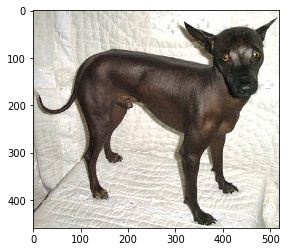

In [15]:
#
#    Test Code Area
#
import matplotlib.pyplot as plt
import matplotlib.transforms as tr
import matplotlib.cbook as cbook
image_file = "/data/dog_images/train/132.Xoloitzcuintli/Xoloitzcuintli_08313.jpg"
#image_file="/data/dog_images/train/008.American_staffordshire_terrier"
#image_path = dog_files[1230]#human_files[0]
#image_file = image_path#cbook.get_sample_data('ada.png')
image      = plt.imread(image_file)

imAx       = plt.imshow(image)
#rot = tr.Affine2D().rotate_deg(0.25)
#imAx.set_transform(imAx.get_transform()+rot)

#plt.axis('off') # clear x- and y-axes
#plt.show()

/data/dog_images/train/100.Lowchen/Lowchen_06676.jpg
/data/dog_images/train/100.Lowchen/Lowchen_06683.jpg
/data/dog_images/train/100.Lowchen/Lowchen_06679.jpg
/data/dog_images/train/100.Lowchen/Lowchen_06701.jpg
/data/dog_images/train/100.Lowchen/Lowchen_06695.jpg


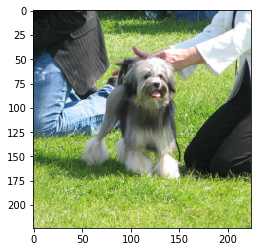

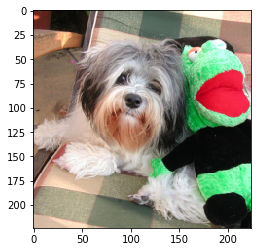

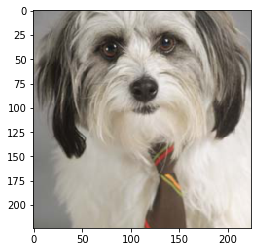

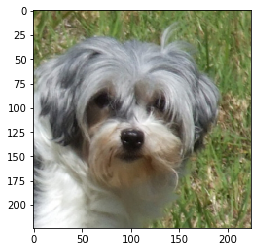

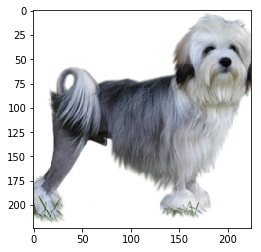

In [33]:
#image_path  = "/home/workspace/dog_project/images/Curly-coated_retriever_03896.jpg"
image_path  = dog_files[5230]
#image_path  = human_files[1900]


count =0
for key in dog_Image_train:
    if count in range(6675, 6680):
        image_path = key
        print(key)
        imshow(pre_process_image(image_path))
        #break
    count = count +1



#index_image = dog_detector(image_path)
#print(index_image)

#imshow(pre_process_image(image_path))
#plt.show(imshow)

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__Please see below.


In [22]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short   = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
count=0
print('*** Performance of the dog_detector when applied to human images  ')
t=tqdm(range(100))
for i in t:
    if dog_detector(human_files_short[i]):
        #print('i is  now: {}'.format(i))
        count += 1
t.clear()
print('Percentage of the images in human_files_short that have detected dog out of 100 are: {}%'.format(100*count/100),'\n')
t=tqdm(range(100))
count=0
print('\n*** Performance of the dog_detector when applied to dog images  ')
for i in t:
    if dog_detector(dog_files_short[i]):
        #print('i is  now: {}'.format(i))
        count += 1
t.clear()
t.refresh()
t.close()
print("Percentage of the images in dog_files_short have detected dog images out of 100 are: {}%".format(100*count/100))


  0%|          | 0/100 [00:00<?, ?it/s]

*** Performance of the dog_detector when applied to human images  



  0%|          | 0/100 [00:00<?, ?it/s]

Percentage of the images in human_files_short that have detected dog out of 100 are: 0.0% 


*** Performance of the dog_detector when applied to dog images  


100%|██████████| 100/100 [01:21<00:00,  1.26it/s]

Percentage of the images in dog_files_short have detected dog images out of 100 are: 100.0%


In [ ]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [45]:
### (Optional) 
# define Resnet50 model
import torch
import torchvision.models as models
RESNET50 = models.resnet50(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    RESNET50 = RESNET50.cuda()
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.



[171]


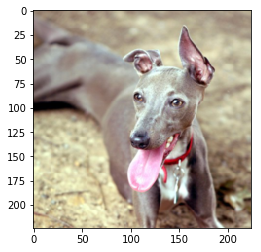

In [46]:
device = 'cpu'
model  =  RESNET50

#image_path  = dog_files[5230]
#image_path  =human_files[1900]
#index_image = dog_detector(image_path)
#print(index_image)

imshow(pre_process_image(image_path))
index_image = VGG16_predict(dog_files[5230])
print(index_image)

In [47]:
count = 0
print('*** Model is: ResNet50.  Performance of the dog_detector when applied to human images  ')
t    = tqdm(range(100))
for i in t:
    if dog_detector(human_files_short[i]):
        #print('i is  now: {}'.format(i))
        count += 1
t.clear()
print(' Model is: ResNet50.  Percentage of the images in human_files_short that have detected dog out of 100 are: {}%'.format(100*count/100),'\n')
t   = tqdm(range(100))
count=0
print('\n***  Model is: ResNet50.  Performance of the dog_detector when applied to dog images  ')
for i in t:
    if dog_detector(dog_files_short[i]):
        #print('i is  now: {}'.format(i))
        count += 1
t.clear()
t.refresh()
t.close()
print(" Model is: ResNet50. Percentage of the images in dog_files_short have detected dog images out of 100 are: {}%".format(100*count/100))

  0%|          | 0/100 [00:00<?, ?it/s]

*** Model is: ResNet50.  Performance of the dog_detector when applied to human images  


  0%|          | 0/100 [00:00<?, ?it/s]

 Model is: ResNet50.  Percentage of the images in human_files_short that have detected dog out of 100 are: 1.0% 


***  Model is: ResNet50.  Performance of the dog_detector when applied to dog images  


100%|██████████| 100/100 [00:32<00:00,  3.21it/s]

 Model is: ResNet50. Percentage of the images in dog_files_short have detected dog images out of 100 are: 99.0%


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [6]:
#
# preprocess the data
# 
    

In [2]:
#
#  This ***KSH*** Split the data set into Train, Test, and Validate
#
dog_Image_train ={}
dog_Image_test  ={}
dog_Image_valid ={}
#word=""
for idx in range(0, len(dog_files), 1): 
    pet_label = ""
    label     = []
    #
    # get pointers to get dog breeds
    #
    start_i  = str(dog_files[idx]).rfind('/')
    end_i    = str(dog_files[idx]).rfind('_')
    #
    # get pointes to mark if data is train,test, or validation
    #
    st_train = str(dog_files[idx]).find('train')
    st_test  = str(dog_files[idx]).find('test')
    st_valid = str(dog_files[idx]).find('valid')
        
    word_list_pet_image =  dog_files[idx][start_i+1:end_i].lower().split('_')
    
    for word in word_list_pet_image:
        #if word.isalpha():
        word = word + " "
        #pet_label = pet_label +" " + word        
        pet_label = pet_label + word  
    # If filename doesn't already exist in dictionary add it and it's
    # pet label - otherwise print an error message because indicates 
    # duplicate files (filenames)
    pet_label = pet_label.strip()
    if st_train   > 0:
        if dog_files[idx] not in dog_Image_train:
            dog_Image_train[dog_files[idx]] = [pet_label,label]#[pet_label]
        else:
            print("** Warning: Duplicate files exist in TRAIN directory:", dog_files[idx])
            break
    elif st_test  > 0:
        if dog_files[idx] not in dog_Image_test:
            dog_Image_test[dog_files[idx]] = [pet_label,label]
        else:
            print("** Warning: Duplicate files exist in TEST directory:", dog_files[idx])
            break
    elif st_valid > 0:
        if dog_files[idx] not in dog_Image_valid:
            dog_Image_valid[dog_files[idx]] = [pet_label,label]
        else:
            print("** Warning: Duplicate files exist in VALID directory:", dog_files[idx])
            break

In [17]:
count =0
for i in dog_Image_train:
    count +=1
    print(count,' ',i,' ',dog_Image_train[i][0])
    #if count == 2:
    #    break

1   /data/dog_images/train/103.Mastiff/Mastiff_06833.jpg   mastiff
2   /data/dog_images/train/103.Mastiff/Mastiff_06826.jpg   mastiff


In [18]:
dog_categories = []
count          = 0
#
# This builds the category list
#
for key in dog_Image_train:
    #dog_labels = [0]*133
    if dog_Image_train[key][0] not in dog_categories:
        dog_categories.append(dog_Image_train[key][0])
        #print(count,' ',dog_categories[count])
        #print('\n')
        count +=1

In [19]:
#
#    Make lables using One-Hot-Encoding  Training  data set too!
#
#   KEEP! Use later for assigning labels to the dog images 28-Jun-2020
#
#for col in data.columns: 
#list(data.columns.values) 
from pandas import DataFrame
#
#  One-Hot-Encode the breeds 
#
df_tst               = pd.DataFrame (dog_categories,columns=['dog breeds'])
df_tst['dog breeds'] = pd.Categorical(df_tst['dog breeds'])
df_dummies           = pd.get_dummies(df_tst['dog breeds'])#,prefix='category' remove the prefix don need it
df_tst               = pd.concat([df_tst,df_dummies],axis=1)
df_tst               = df_tst.drop(['dog breeds'], axis=1)

for key in dog_Image_train:
    dog_Image_train[key][1] = np.array(df_tst[dog_Image_train[key][0]])
    #print('\n--> key -->',key,' *** Breed: ',dog_Image_train[key][0],' label:',dog_Image_train[key][1])


In [20]:
#
#    Make lables using One-Hot-Encoding  VALID data set!
#
#   KEEP! Use later for assigning labels to the dog images 28-Jun-2020
#df_tst               = pd.DataFrame (dog_categories,columns=['dog breeds'])
#df_tst['dog breeds'] = pd.Categorical(df_tst['dog breeds'])
#df_dummies           = pd.get_dummies(df_tst['dog breeds'])#,prefix='category' remove the prefix don need it
#df_tst               = pd.concat([df_tst,df_dummies],axis=1)
#df_tst               = df_tst.drop(['dog breeds'], axis=1)

for key in dog_Image_valid:
    dog_Image_valid[key][1] = np.array(df_tst[dog_Image_valid[key][0]])
    #print('\n--> key -->',key,' *** Breed: ',dog_Image_valid[key][0],' label:',dog_Image_valid[key][1])
    
        #if dog_Image_train[key][0] == col:
        #    print('Found match --> key --> {} col-name is: {}'.format(key,col))
        #    dog_Image_train[key][1] == df_tst[col]
del df_tst
del df_dummies

In [21]:
#
#    Need to do Data Exploration of dog images   
#
import cv2                
img = cv2.imread(dog_files[1010])
print(dog_files[1010])
print('shape :',img.shape)
print()
#ht, wth, channel = img.shape
ht, wth, _ = img.shape
print('Ht {}, whidth {}, Channel'.format(ht,wth))

/data/dog_images/train/034.Boxer/Boxer_02425.jpg
shape : (805, 871, 3)

Ht 805, whidth 871, Channel




Dog Image Median: Height    466.0
Width     500.0
dtype: float64  Mean: Height    532.157485
Width     571.382335
dtype: float64  Standard Deviation Height    341.626020
Width     397.480566
dtype: float64


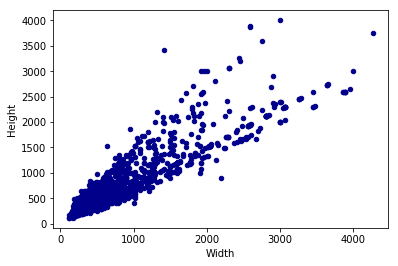

In [22]:
#
#  Graph all training Dog Image size distributions
#
img_lst =[]

for key in dog_Image_train:
    tmp_l = []
    img   = cv2.imread(key)
    ht, wth, _ = img.shape
    tmp_l.append(ht)
    tmp_l.append(wth)
    img_lst.append(tmp_l)
    
df_dog_img = DataFrame(img_lst)
Cols = ['Height', 'Width'] 
df_dog_img.columns=Cols
#df_dog_img
df_dog_img.plot.scatter(x='Width',y='Height',c='DarkBlue')
print('\n')
print('Dog Image Median: {}  Mean: {}  Standard Deviation {}'.format(df_dog_img.median(),df_dog_img.mean(),df_dog_img.std()))




Median : Height    250.0
Width     250.0
dtype: float64    Mean : Height    250.0
Width     250.0
dtype: float64   Standard Deviation Height    0.0
Width     0.0
dtype: float64


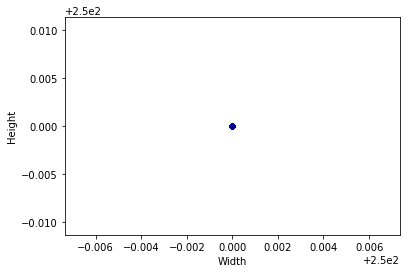

In [23]:
#
#  Graph all training Human Face Images size distributions
#
img_lst =[]

for key in human_files:
    tmp_l = []
    img   = cv2.imread(key)
    ht, wth, _ = img.shape
    tmp_l.append(ht)
    tmp_l.append(wth)
    img_lst.append(tmp_l)
    
df_human_img = DataFrame(img_lst)
Cols = ['Height', 'Width'] 
df_human_img.columns=Cols
df_human_img.plot.scatter(x='Width',y='Height',c='DarkBlue') #colormap='viridis'
print('\n')
print('Median : {}    Mean : {}   Standard Deviation {}'.format(df_human_img.median(),df_human_img.mean(),df_human_img.std()))

In [24]:
del df_human_img
del df_dog_img
del img_lst

In [26]:
#
# Create a DataFrame for more visualization and analysis
#

from pandas import DataFrame
df_train = pd.DataFrame(dict([ (k,pd.Series(v[0])) for k,v in dog_Image_train.items() ])).melt().dropna()
print(df_train.columns)
cols     = ['Dog Image','Breed']
df_train.columns =cols
print(df_train.columns)

Index(['variable', 'value'], dtype='object')
Index(['Dog Image', 'Breed'], dtype='object')


In [27]:
#
#  Group the dog breed types and count the number of images per breed in the training data set
#
count = df_train.groupby(['Breed']).count() 
print('\n\n\rThe mean for breed is:{} '.format(count.mean().round()))
print("The std for breed is:{} ".format(count.std().round()))
print('\n\n')
#print(count.describe,'\n\r')




The mean for breed is:Dog Image    50.0
dtype: float64 
The std for breed is:Dog Image    12.0
dtype: float64 






The number of Dog-images appearing in each of the 11 Ranges/Bins is : [ 3  5  9 10 11 11 15 19 24 26]
The distribution of Dog-image breeds ranges from 26.0 to 77.0 and it show IMBALANCE of the data set.
The histogram below clearly illustraites the imbalance of Dog-image distribution


(array([  3.,   5.,   9.,  10.,  11.,  11.,  15.,  19.,  24.,  26.]),
 array([ 26. ,  31.1,  36.2,  41.3,  46.4,  51.5,  56.6,  61.7,  66.8,
         71.9,  77. ]),
 <a list of 10 Patch objects>)

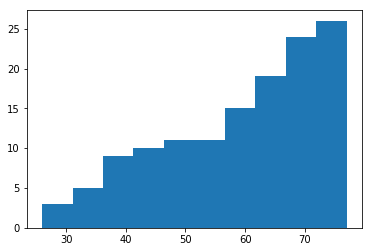

In [28]:
#
#      Separate out the 
#
import matplotlib.pyplot as plt
counts, bins = np.histogram(count,density=False)#Density=True
counts       = np.sort(counts)
print('\nThe number of Dog-images appearing in each of the {} Ranges/Bins is : {}'.format(len(bins),counts))
print('The distribution of Dog-image breeds ranges from {} to {} and it show IMBALANCE of the data set.'.format(min(bins),max(bins)))
print('The histogram below clearly illustraites the imbalance of Dog-image distribution')
plt.hist(bins[:-1], bins, weights=counts)



Skewness should be 0 for a Balanced data set,i.e., denotes a symmetrical distribution 
  the value of skew is negative so the skewness is an asymmetrical distribution;
  the asymmetrical distribution is toward the left side of the curve.

Skewness = :  Dog Image   -0.07762
dtype: float64

Kurtosis = :  Dog Image   -0.728101
dtype: float64

Median = :  Dog Image    50.0
dtype: float64


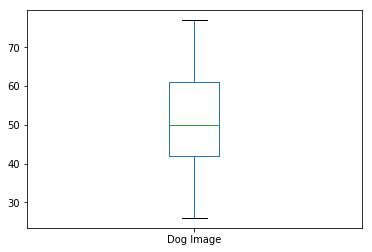

In [29]:
count.plot.box()
print('\n')
print('Skewness should be 0 for a Balanced data set,i.e., denotes a symmetrical distribution ')
print('  the value of skew is negative so the skewness is an asymmetrical distribution;')
print('  the asymmetrical distribution is toward the left side of the curve.')
skewValue=count.skew()#axis = 0, skipna = True
print('\nSkewness = : ',skewValue)
kurt = count.kurt();
print('\nKurtosis = : ',kurt)
kurt = count.kurt();
print('\nMedian = : ',count.median())


 Image Count per Dog-Breed; IMBALANCED 


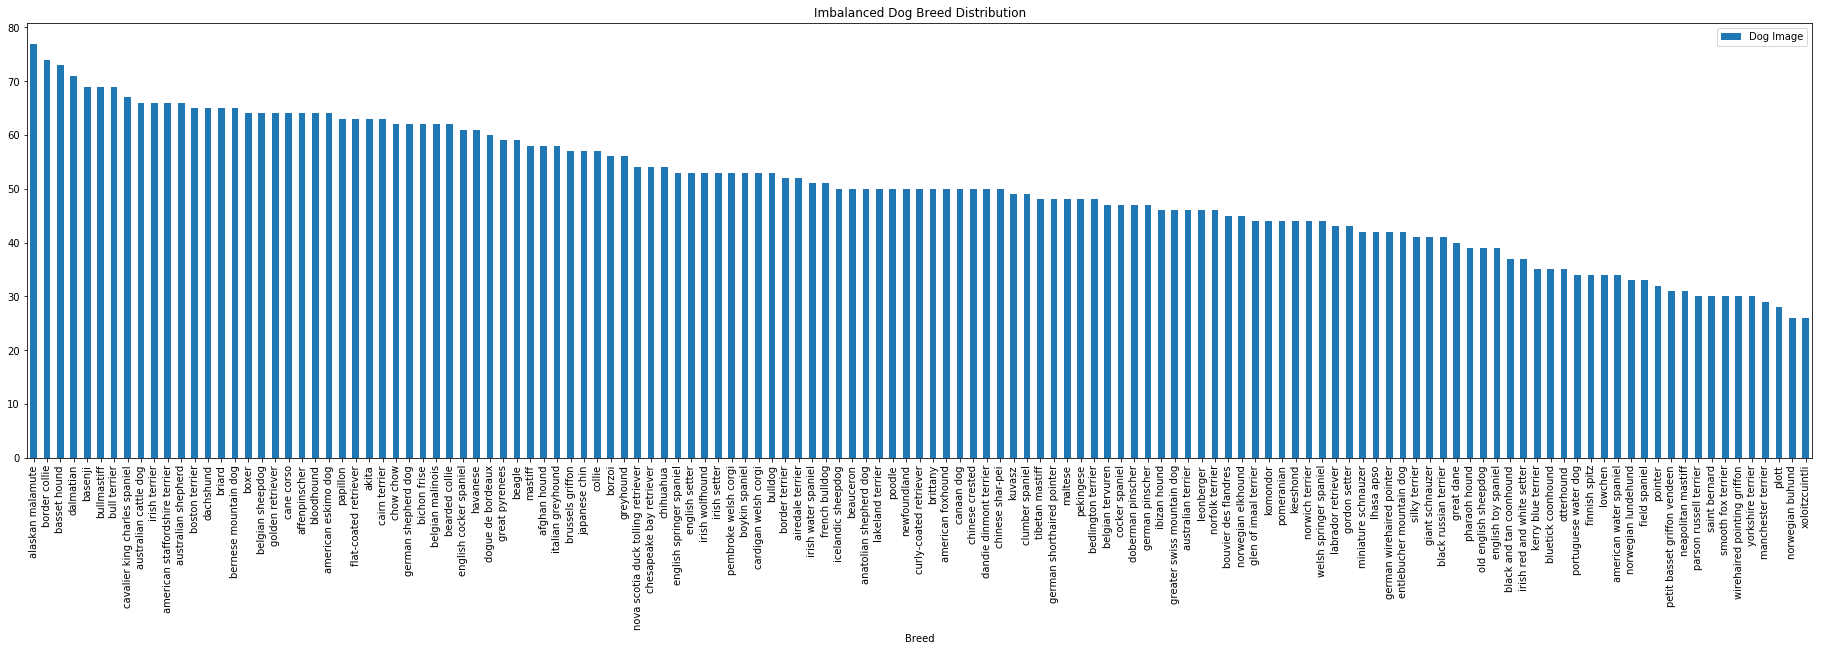

In [30]:
#import matplotlib.pyplot as plt
print('\n\r Image Count per Dog-Breed; IMBALANCED ')
count.sort_values(by='Dog Image',ascending=False).plot.bar(title="Imbalanced Dog Breed Distribution",figsize=(32,8))#rot=70,


In [2]:
#
#  Set up the pointers to the directory
#
import os
from pathlib import Path  #/home/workspace/dog_project/images

data_dir   = "/data/dog_images/"
train_dir  = os.path.join(data_dir, 'train/')
valid_dir  = os.path.join(data_dir, 'valid/')
test_dir   = os.path.join(data_dir, 'test/')

#os.chdir('/home/workspace/dog_project/images/')
#os.chdir(train_dir)
#print(os.getcwd())
#print(*Path(train_dir).iterdir(), sep="\n")


In [3]:
#
#  All images are PRE-LABLED ..sure wish I knew this bfore spending time to lable them!
#
#  set up the transfroms


from torchvision import datasets

#from torchvision import datasets

import torch.utils.data


train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),  # Test Transformation
                      transforms.CenterCrop(224),
                      transforms.ToTensor(),
                      transforms.Normalize([ 0.485, 0.456, 0.406], 
                                           [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(256),  # Validation Transformation       
                      transforms.CenterCrop(224),
                      transforms.ToTensor(),
                      transforms.Normalize([ 0.485, 0.456, 0.406], 
                                           [0.229, 0.224, 0.225])])

# ImageFolder applies transforms to each image within each folder.

train_data      = datasets.ImageFolder(train_dir, transform = train_transforms)
test_data       = datasets.ImageFolder(train_dir, transform = test_transforms)
valid_data      = datasets.ImageFolder(train_dir, transform = valid_transforms)




In [4]:
#
#
#    Loaders for Training, Validation, and Test
#
import os
from torchvision import datasets
from PIL import ImageFile
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
loaders           = {}
scratch_loaders   = {}
loaders['train']  =  torch.utils.data.DataLoader(train_data, batch_size = 32, shuffle=True,drop_last=True)#64 was the batchsize changed to 32
loaders['test']   =  torch.utils.data.DataLoader(test_data,  batch_size = 32)
loaders['valid']  =  torch.utils.data.DataLoader(valid_data, batch_size = 32)

loaders_scratch = loaders


ImageFile.LOAD_TRUNCATED_IMAGES = True
#for batch_idx, (data, target) in enumerate(loaders['train']):
#   print('Number of records read',batch_idx,' shape of data',data.shape,'shape of target',target.shape)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

Question #1

- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?


(1) Training images are resied are centered-croped to 224 pixels; the mean is set to [0.485, 0.456, 0.406] and standard set to [0.229, 0.224, 0.225]  from center;the images are flipped and randomly rotated. 
(2) Test images are simply resized to 256 whilst the mean of the height and width are 466 and 532 respectively I wanted to focus closer to the center for testing. Center cropping is the same are training, 244.
(3) Vlaidation images are the same configurations as for test above.


Question #2

- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


(1) The dataset for training was augmented by rotation and flipping the images to better tune the training.
(2) All three datasets where normalized around the mean and standard deviation vectors and are identical.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [5]:
def set_environment(model):
    if torch.cuda.is_available():
        device ='cuda'
    else:
        device ='cpu'
    model.to(device)
    print("\n *** inside set_environment for device:-> ",device,model)

In [6]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()


In [8]:
#
#  *** KEEP ***  17-Jul-20  DID WORK WELL using Mentors' architecture
#
import torch.nn as nn
import torch.nn.functional as F
drop_p = 0.2
# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #
        #  Convolution layers for featrue processing & reduction
        #
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1), # Inital channel is 3 for RGB and start with 32 ConvFilters; a 5x5 Conv2D kernel; formula for padding results in 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), # kernel_size was 5
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #self.layer4 = nn.Sequential(
        #    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        #    nn.ReLU(),
        #    nn.MaxPool2d(kernel_size=2, stride=2))
        

        self.drop_out = nn.Dropout(drop_p)

        self.fc1 = nn.Linear(28*28*64, 500)  # Image size sequence step down 224->112->56->28
        self.fc2 = nn.Linear(500, 500)# 
        self.fc3 = nn.Linear(500, 133)# 
        
        # Batch normaliztion: accelerates learning
        #
        # This removes the phenomenon of internal covariate shift, and address the problem by normalizing layer inputs.
        # Our method draws its strength from making normalization a part of the model architecture and performing the
        # normalization for each training mini-batch. Batch Normalization allows us to use much higher learning rates
        # and be less careful about initialization. It also acts as a regularizer, in some cases eliminating the need 
        # for Dropout. 
        #
        self.batch_norm = nn.BatchNorm1d(num_features=500)# Set to 500 as per Fc1 and Fc2
        
    def forward(self, out):
        #
        #  Feature processing; convolution
        #
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        #
        #  Flatten
        #
        out = out.view(out.size(0), -1)# 
        #print('\n\n******* After  Flatten ****** >>> ',len(out),
        #      ' Type: ',type(out),' shape ',out.shape,
        #      '\n')
        
        #
        # Fully connected layers 1-3 
        #
        out = self.drop_out(out) # 
        out = self.batch_norm(self.fc1(out)) # Batch normaliztion: accelerates learning
        
        out = self.drop_out(out) # 
        out = self.batch_norm(self.fc2(out)) # Batch normaliztion: accelerates learning
        
        out = self.drop_out(out)
        out = self.fc3(out)
        
        return out

In [9]:
# instantiate the CNN
model_scratch = Net()


# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

set_environment(model_scratch)


 *** inside set_environment for device:->  cpu Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop_out): Dropout(p=0.2)
  (fc1): Linear(in_features=50176, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=500, bias=True)
  (fc3): Linear(in_features=500, out_features=133, bias=True)
  (batch_norm): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [58]:
#
#   Original code
#
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
    
    def forward(self, x):
        ## Define forward behavior
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

For this NN from-scratch modle I decided on three hidden layers; Layer one will have 25,088 inputs going to H1 with 12,544 nodes. H1 terminates to h2  with 4096 nodes, h3 is 4096 to 4096, h4 takes in 4096 to 1024, Finally the output layer is 1024 to 133, the number of do breeds. The initial input and h1 layes are highly componentized so they can increase the componentizations of the image and increase the probability of matching.  Layers three through the final are standard breakdowns that I discovered.  The regularizaton function choosen is random dropout starting with 20%. in the forwarding method I added an extra function to ensure that the tensor vector is a flatten image.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [10]:
import torch.optim as optim
learnR      = 0.001 #: this appears best for the 3x hidden layers that increases accuray steadily
### TODO: select loss function
criterion_scratch = nn.NLLLoss() #None


### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(),learnR) #

In [12]:
#
# Test Code train 16-Jul-20
#
#
#
#
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

def tst_train(n_epochs, loaders, model, optimizer, criterion, use_cuda):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    
    valid_loss_min = np.Inf 
    steps          = 0
    train_losses, test_losses = [], []
    
   
    
    for epoch in range(1, n_epochs+1):        
        train_loss = 0.0
        test_loss  = 0.0
        train_loss2= 0.0
        
        ###################
        # train the model #
        ###################
        #model.train()   16-Jul-20
        
        #  data   = inputs
        #  target = labels
        
        ImageFile.LOAD_TRUNCATED_IMAGES = True

        for batch_idx, (image_data, label_target) in enumerate(loaders['train']):
            #print('type of image as data',type(image_data))
            #print('image shape',image_data.shape)
            #print('target shape',label_target.shape)
            if use_cuda:
                image_data, label_target = image_data.cuda(), image_target.cuda()
            
            steps +=1
            optimizer.zero_grad()                 # clear out optimizer
            output  = model( image_data )               # train on the input image data
            loss    = criterion(output, label_target )  # Calculate loss passing the output and the labels
            
            # Backdrop and preform Adam optimization
            
            loss.backward()
            optimizer.step()                      # update the weights in the moddle for all layers
            #optimizer.zero_grad()                 # clear out optimizer
            
            train_loss   = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))# ***
            train_loss2 += loss.item()
            
            print('\nloss1  Model fwd called w/ batch idx',batch_idx,'train_loss {:.6f}'.format(train_loss))
            #print('loss2  Model fwd called w/ batch idx',batch_idx,'train_loss2 {:.6f}'.format(train_loss2))

            
        model.train()   #16-Jul-20


In [13]:
# train the model
#use_cuda =F
tst_train(1, loaders, model_scratch, optimizer_scratch, criterion_scratch,use_cuda)


loss1  Model fwd called w/ batch idx 0 train_loss 0.038905

loss1  Model fwd called w/ batch idx 1 train_loss 0.037939

loss1  Model fwd called w/ batch idx 2 train_loss 0.000883

loss1  Model fwd called w/ batch idx 3 train_loss 0.003775

loss1  Model fwd called w/ batch idx 4 train_loss -0.037106

loss1  Model fwd called w/ batch idx 5 train_loss -0.019163

loss1  Model fwd called w/ batch idx 6 train_loss -0.024591

loss1  Model fwd called w/ batch idx 7 train_loss -0.059098

loss1  Model fwd called w/ batch idx 8 train_loss -0.046995

loss1  Model fwd called w/ batch idx 9 train_loss -0.053909

loss1  Model fwd called w/ batch idx 10 train_loss -0.059560

loss1  Model fwd called w/ batch idx 11 train_loss -0.066097

loss1  Model fwd called w/ batch idx 12 train_loss -0.074870

loss1  Model fwd called w/ batch idx 13 train_loss -0.083099

loss1  Model fwd called w/ batch idx 14 train_loss -0.095180

loss1  Model fwd called w/ batch idx 15 train_loss -0.100892

loss1  Model fwd call

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [ ]:
plt.plot(train_losses,label = 'Training loss')
plt.plot(test_losses,label = 'Validation loss')
plt.legend(frameon=False)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
            
    # return trained model
    return model


# train the model
model_scratch = train(100, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [ ]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
## TODO: Specify data loaders


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [ ]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 


if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [ ]:
criterion_transfer = None
optimizer_transfer = None

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [ ]:
# train the model
model_transfer = # train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [ ]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [ ]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def predict_breed_transfer(img_path):
    # load the image and return the predicted breed
    return None

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [ ]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

In [ ]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)